In [53]:
# data processing
import pandas as pd
import numpy as np

# modelling
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report, auc, roc_curve, accuracy_score, precision_recall_curve, precision_recall_fscore_support
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [54]:
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

x_train, x_val = train_test_split(train_images, test_size=0.2, random_state=42)

Dataset split: 48000 train rows
Dataset split: 12000 test rows


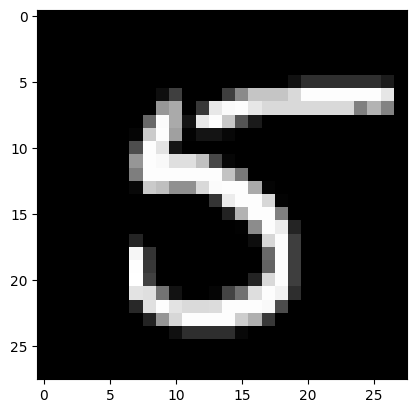

In [55]:
print(f"Dataset split: {len(x_train)} train rows")
print(f"Dataset split: {len(x_val)} test rows")

point = x_train[0].reshape(28, 28)

plt.imshow(point, cmap='gray')
plt.show()

In [56]:
print(x_train.shape)
print(x_val.shape)
print(test_images.shape)

(48000, 28, 28)
(12000, 28, 28)
(10000, 28, 28)


In [57]:
# normalize data
x_train = x_train.astype(np.float32) / 255
x_val = x_val.astype(np.float32) / 255

# reshape
x_train = x_train.reshape(-1, 784)
x_val = x_val.reshape(-1, 784)
test_images = test_images.reshape(-1, 784)

In [58]:
print(x_train.shape)
print(x_val.shape)
print(test_images.shape)

(48000, 784)
(12000, 784)
(10000, 784)


In [59]:
latent_dim = 2

In [60]:
# encoder
vae_input = keras.layers.Input(shape=(784,))
x = keras.layers.Dense(256, activation='relu')(vae_input)
x = keras.layers.Dense(128, activation='relu')(x)
z_mean = keras.layers.Dense(latent_dim)(x)
z_log_var = keras.layers.Dense(latent_dim)(x)

In [61]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.keras.backend.random_normal(shape=tf.shape(z_mean), mean=0., stddev=1.0)
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [62]:
z = keras.layers.Lambda(lambda x: sampling(x))([z_mean, z_log_var])

In [63]:
# decoder
decoder_input = keras.layers.Input(shape=(latent_dim,))
x = keras.layers.Dense(128, activation='relu')(decoder_input)
x = keras.layers.Dense(256, activation='relu')(x)
x = keras.layers.Dense(784, activation='sigmoid')(x)
decoded = x

In [64]:
# Encoder model
encoder = keras.models.Model(inputs=vae_input, outputs=[z_mean, z_log_var, z])

# Decoder model
decoder = keras.models.Model(inputs=decoder_input, outputs=decoded)

In [65]:
vae_output = decoder(encoder(vae_input)[2])
vae = keras.models.Model(inputs=vae_input, outputs=vae_output)

In [66]:
def vae_loss(x, x_decoded_mean):
    reconstruction_loss = tf.reduce_mean(tf.square(x - x_decoded_mean))
    kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
    kl_loss = -0.5 * tf.reduce_mean(kl_loss, axis=-1)
    vae_loss = reconstruction_loss + kl_loss
    return vae_loss

vae.add_loss(vae_loss(vae_input, vae_output))

In [67]:
vae.compile(optimizer='adam')

In [68]:
vae.fit(x_train, x_train, epochs=20, batch_size=64, validation_data=(x_val, x_val))

Epoch 1/20


750/750 [==============================] - 4s 4ms/step - loss: 0.0724 - val_loss: 0.0672
Epoch 2/20
750/750 [==============================] - 3s 4ms/step - loss: 0.0675 - val_loss: 0.0672
Epoch 3/20
750/750 [==============================] - 3s 4ms/step - loss: 0.0674 - val_loss: 0.0672
Epoch 4/20
750/750 [==============================] - 3s 4ms/step - loss: 0.0674 - val_loss: 0.0672
Epoch 5/20
750/750 [==============================] - 3s 4ms/step - loss: 0.0674 - val_loss: 0.0671
Epoch 6/20
750/750 [==============================] - 3s 4ms/step - loss: 0.0674 - val_loss: 0.0671
Epoch 7/20
750/750 [==============================] - 3s 4ms/step - loss: 0.0674 - val_loss: 0.0671
Epoch 8/20
750/750 [==============================] - 3s 4ms/step - loss: 0.0674 - val_loss: 0.0671
Epoch 9/20
750/750 [==============================] - 3s 4ms/step - loss: 0.0674 - val_loss: 0.0670
Epoch 10/20
750/750 [==============================] - 3s 4ms/step - loss: 0.0673 - val_loss: 0.0671
Epoch 11/2

In [69]:
decoded_images = vae.predict(test_images)

# calculate the reconstruction error for each sample
reconstruction_errors = np.mean(np.square(test_images - decoded_images), axis=1)

313/313 [==============================] - 0s 1ms/step


In [70]:
# define a threshold for anomaly detection
threshold = np.percentile(reconstruction_errors, 95)

# Identify anomalies based on the threshold
anomaly_indexes = np.where(reconstruction_errors > threshold)[0]

In [71]:
# Get all the anomalies from the test_images
anomalies = test_images[anomaly_indexes]

# Create binary labels where 1 represents anomalies and 0 represents non-anomalies
anomaly_labels = np.where(reconstruction_errors > threshold, 1, 0)

In [72]:
print(len(anomalies))

500


In [73]:
# Save the anomaly indexes to a file
with open("anomaly_indexes.txt", "w") as file:
    for idx in anomaly_indexes:
        file.write(str(idx) + "\n")

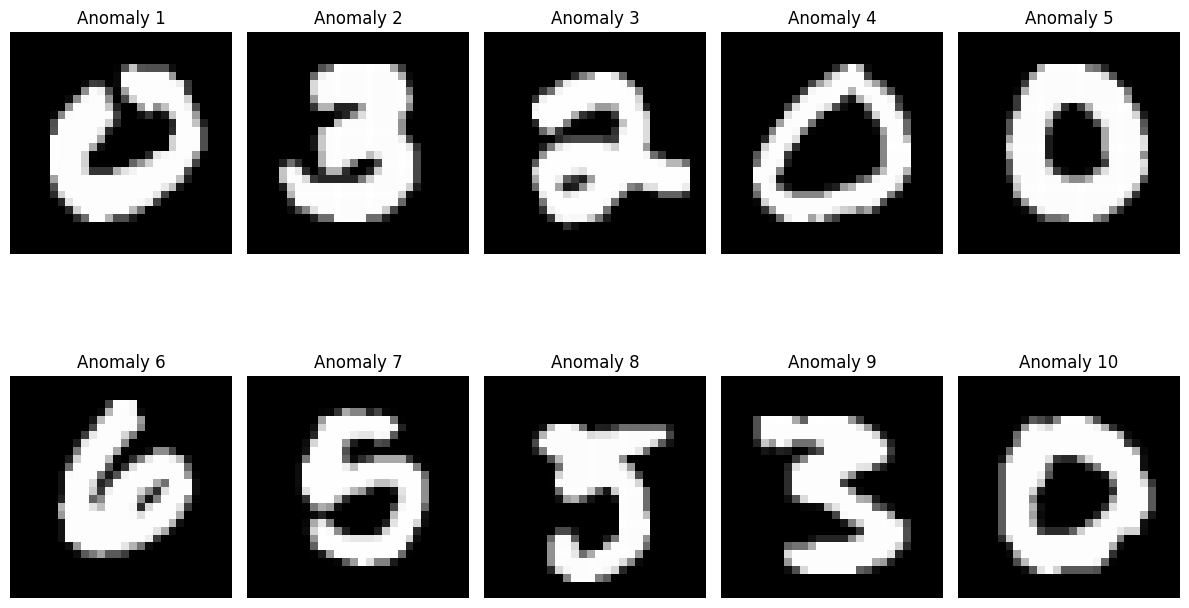

In [74]:
# Plot some of the anomalies
plt.figure(figsize=(12, 8))
for i, idx in enumerate(anomaly_indexes[:10]):  # Plot the first 10 anomalies
    plt.subplot(2, 5, i + 1)
    plt.imshow(test_images[idx].reshape(28, 28), cmap='gray')
    plt.title(f'Anomaly {i+1}')
    plt.axis('off')
plt.tight_layout()
plt.show()

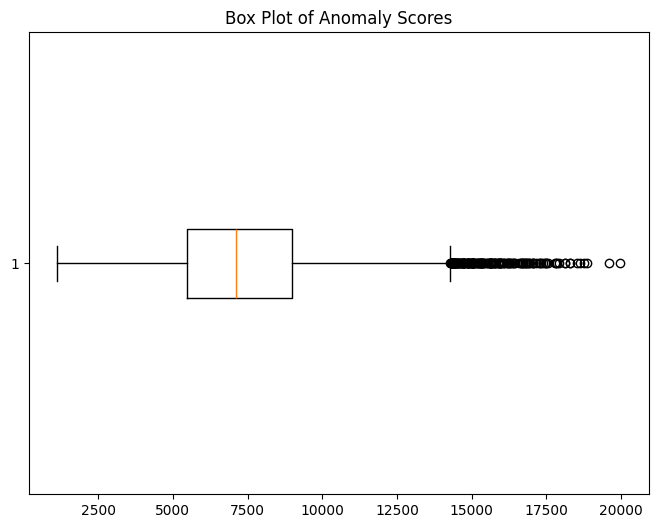

In [75]:
plt.figure(figsize=(8, 6))
plt.boxplot(reconstruction_errors, vert=False)
plt.title('Box Plot of Anomaly Scores')
plt.show()

In [76]:
# calculate the true positve rate and false positive rate for different threshold levels
y_true = [1 if i in anomalies else 0 for i in range(len(test_images))]

# calculate the precision, recall, and f1 score
precision, recall, f1, _ = precision_recall_fscore_support(y_true, anomaly_labels)

# print precision, recall, and f1 score
print(f'Precision: {precision[1]:.2f}')
print(f'Recall: {recall[1]:.2f}')
print(f'F1 Score: {f1[1]:.2f}')

Precision: 0.01
Recall: 0.01
F1 Score: 0.01


In [77]:
# calculate the precision and recall for different threshold levels
precision, recall, thresholds = precision_recall_curve(y_true, reconstruction_errors)

# calculate the area under the precision-recall curve
pr_auc = auc(recall, precision)

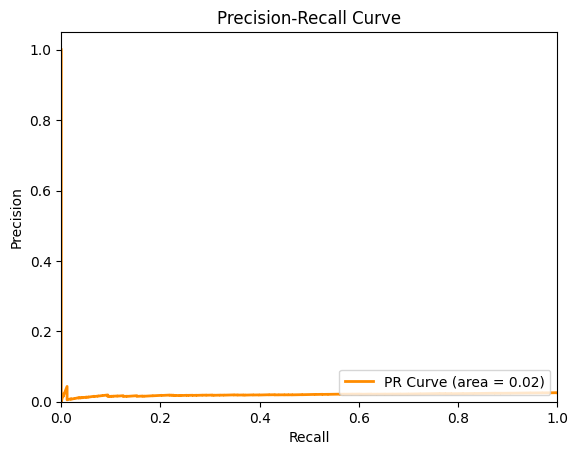

In [78]:
plt.figure()
plt.plot(recall, precision, color='darkorange', lw=2, label='PR Curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower right')
plt.show()

In [79]:
# create binary labels for anomalies and generate a classification report
# binary labels where 1 represents anomalies and 0 represents non-anomalies
anomaly_labels = np.where(reconstruction_errors > threshold, 1, 0)
report = classification_report(y_true, anomaly_labels)
print(report)

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      9744
           1       0.01      0.01      0.01       256

    accuracy                           0.93     10000
   macro avg       0.49      0.48      0.48     10000
weighted avg       0.95      0.93      0.94     10000

